<a href="https://colab.research.google.com/github/parsa-abbasi/Hands-on-NLP/blob/master/NLPinTensorFlow/Exercises/Exercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 2
This week you will build on last week’s exercise where you tokenized words from the BBC news reports dataset. This dataset contains articles that are classified into a number of different categories. See if you can design a neural network that can be trained on this dataset to accurately determine what words determine what category. Create the vecs.tsv and meta.tsv files and load them into the embedding projector.

## Get dataset

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

## Import libraries

In [0]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Set parameters

In [0]:
vocab_size = 900
embedding_dim = 32
max_length = 128
trunc_type = 'post'
padding_type = 'post'
oov_tok = 'OOV'
training_portion = .8

## Stopwords

In [0]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))

153


## Extract data

In [0]:
sentences = []
labels = []

with open("/tmp/bbc-text.csv", 'r') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    next(csv_reader) # Skip header
    for row in csv_reader:
      labels.append(row[0]) # Add label/category
      text = row[1]
      sentence = ' '.join([word for word in text.split() if word not in stopwords]) # Remove stopwords
      sentences.append(sentence) # Add sentence/text

In [0]:
print(len(labels))
print(len(sentences))
print(sentences[0])

2225
2225
tv future hands viewers home theatre systems plasma high-definition tvs digital video recorders moving living room way people watch tv will radically different five years time. according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend programmes content will delivered viewers via home networks cable satellite telecoms companies broadband service providers front rooms portable devices. one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes like us s tivo uk s sky+ system allow people record store play pause forward wind tv programmes want. essentially technology allows much personalised tv. also built-in high-definition tv sets big business japan us slower take off europe lack high-definition programming. not can people forward wind adverts can also forget abiding network channel schedules putting together a-la-carte entertainment. us networks cab

## Prepare training and validation sets

In [0]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

In [0]:
print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

1780
1780
1780
445
445


## Word encoding

In [0]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

In [0]:
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

449
128
200
128
192
128


In [0]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

In [0]:
print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 128)


## Label encoding

In [0]:
label_tokenizer = Tokenizer() # Set up a new tokenizer
label_tokenizer.fit_on_texts(labels)
label_index = label_tokenizer.word_index

# Labels must be converted to numpy array
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [0]:
print(label_index)

{'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}


In [0]:
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


## Neural network model

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(36, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

W0817 12:42:30.333616 140577854039936 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0817 12:42:30.340462 140577854039936 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 32)           28800     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 36)                1188      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 222       
Total params: 30,210
Trainable params: 30,210
Non-trainable params: 0
_________________________________________________________________


In [0]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 1780 samples, validate on 445 samples
Epoch 1/30
1780/1780 - 1s - loss: 1.7472 - acc: 0.3719 - val_loss: 1.6882 - val_acc: 0.4809
Epoch 2/30
1780/1780 - 0s - loss: 1.6157 - acc: 0.5522 - val_loss: 1.5318 - val_acc: 0.5461
Epoch 3/30
1780/1780 - 0s - loss: 1.4222 - acc: 0.6017 - val_loss: 1.3196 - val_acc: 0.6539
Epoch 4/30
1780/1780 - 0s - loss: 1.1601 - acc: 0.8022 - val_loss: 1.0540 - val_acc: 0.8135
Epoch 5/30
1780/1780 - 0s - loss: 0.8806 - acc: 0.8798 - val_loss: 0.8125 - val_acc: 0.8966
Epoch 6/30
1780/1780 - 0s - loss: 0.6451 - acc: 0.9303 - val_loss: 0.6149 - val_acc: 0.9146
Epoch 7/30
1780/1780 - 0s - loss: 0.4734 - acc: 0.9416 - val_loss: 0.4840 - val_acc: 0.9236
Epoch 8/30
1780/1780 - 0s - loss: 0.3532 - acc: 0.9528 - val_loss: 0.3992 - val_acc: 0.9191
Epoch 9/30
1780/1780 - 0s - loss: 0.2765 - acc: 0.9596 - val_loss: 0.3390 - val_acc: 0.9169
Epoch 10/30
1780/1780 - 0s - loss: 0.2201 - acc: 0.9669 - val_loss: 0.3016 - val_acc: 0.9169
Epoch 11/30
1780/1780 - 0s - los

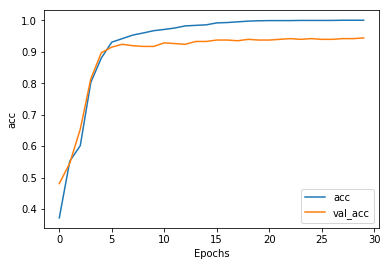

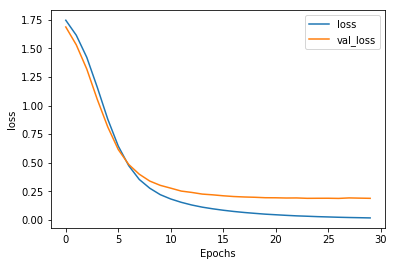

In [0]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

# Visualization of Embedding

Visualizing embedded words using TensorFlow Projector

*   First, make vectors and metadata .tsv files
*   Then, load them into [https://projector.tensorflow.org/](https://projector.tensorflow.org/)





In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(900, 32)


In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')